In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import seaborn as sns

# EDA + Preprocess + PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Classifiers
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV 

In [2]:
# Relabel columns
cols = ["Age", "Work", "FinalWeight", "Education", "EducationVal", "MarriageType",
        "Job", "Relationship", "Race", "Gender", "Gain", "Loss", "HoursWorked", "Country",
        "IncomeType"]

# https://archive.ics.uci.edu/ml/datasets/Adult
income_data = pd.read_csv('Data/adult.data', names=cols)
income_data_test = pd.read_csv('Data/adult.test', names=cols)

# First row of test set is garbage so remove; Concatenate UCI's test + train
income_data_test = income_data_test.iloc[1:]
income_df = pd.concat([income_data, income_data_test])
income_df['IncomeType'] = income_df['IncomeType'].map({' <=50K':1,' <=50K.':1,' >50K':-1, ' >50K.':-1})
income_df['IncomeType'].astype('int32')
income_df['IncomeType'].value_counts()

 1    37155
-1    11687
Name: IncomeType, dtype: int64

In [3]:
income_df.head()

,Age,Work,FinalWeight,Education,EducationVal,MarriageType,Job,Relationship,Race,Gender,Gain,Loss,HoursWorked,Country,IncomeType
0,39,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,1
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,1
2,38,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,1
3,53,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,1
4,28,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,1


In [4]:
print("Shape of income dataset: ", income_df.shape)

Shape of income dataset:  (48842, 15)


### Data Preprocessing

In [5]:
print("Any null values for income set: ", income_df.isnull().values.any())

Any null values for income set:  False


In [6]:
#Remove unnecessary columns
income_df.drop("Gain", axis=1, inplace=True)
income_df.drop("Loss", axis=1, inplace=True)
#Since education 
income_df.drop("Education", axis=1, inplace=True)

In [7]:
income_df.head()

,Age,Work,FinalWeight,EducationVal,MarriageType,Job,Relationship,Race,Gender,HoursWorked,Country,IncomeType
0,39,State-gov,77516.0,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,40.0,United-States,1
1,50,Self-emp-not-inc,83311.0,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,13.0,United-States,1
2,38,Private,215646.0,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,40.0,United-States,1
3,53,Private,234721.0,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40.0,United-States,1
4,28,Private,338409.0,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40.0,Cuba,1


In [8]:
income_df.columns

Index(['Age', 'Work', 'FinalWeight', 'EducationVal', 'MarriageType', 'Job',
       'Relationship', 'Race', 'Gender', 'HoursWorked', 'Country',
       'IncomeType'],
      dtype='object')

In [9]:
le = LabelEncoder()

def data_transform(df):
    df['Work']= le.fit_transform(df['Work'])
    df['MarriageType']= le.fit_transform(df['MarriageType'])
    df['Job']= le.fit_transform(df['Job'])
    df['Relationship']= le.fit_transform(df['Relationship'])
    df['Race']= le.fit_transform(df['Race'])
    df['Gender']= le.fit_transform(df['Gender'])
    df['IncomeType']= le.fit_transform(df['IncomeType'])
    df['Country']= le.fit_transform(df['Country'])
    return df

income_df = data_transform(income_df)

In [10]:
income_df.head()

,Age,Work,FinalWeight,EducationVal,MarriageType,Job,Relationship,Race,Gender,HoursWorked,Country,IncomeType
0,39,7,77516.0,13.0,4,1,1,4,1,40.0,39,1
1,50,6,83311.0,13.0,2,4,0,4,1,13.0,39,1
2,38,4,215646.0,9.0,0,6,1,4,1,40.0,39,1
3,53,4,234721.0,7.0,2,6,0,2,1,40.0,39,1
4,28,4,338409.0,13.0,2,10,5,2,0,40.0,5,1


In [11]:
income_df['IncomeType'].value_counts()

1    37155
0    11687
Name: IncomeType, dtype: int64

In [12]:
# Partition Data into Train and Test
income_y = income_df['IncomeType'].values
income_y = income_y.reshape(len(income_y), 1)
income_X_df = income_df.drop("IncomeType", axis=1)
income_X = income_X_df.values

In [13]:
from sklearn.model_selection import train_test_split
# Stack them together for shuffling.
X_and_Y = np.hstack((income_X, income_y))
X_and_Y = shuffle(X_and_Y)
# Training takes too long on full 44000 set
reduced_X_and_Y = X_and_Y[:10000]

In [14]:
train_partition_80_20 = []
test_partition_80_20 = []
train_partition_20_80 = []
test_partition_20_80 = []
train_partition_50_50 = []
test_partition_50_50 = []

for val in range(3):
    # Different trials (Shuffles)
    cur_X_and_Y = shuffle(reduced_X_and_Y)
    # Reduce training and testing data data by norm + pca
    scaler_80_20 = StandardScaler()
    scaler_50_50 = StandardScaler()
    scaler_20_80 = StandardScaler()
    
    pca_80_20 = PCA(.95)
    pca_50_50 = PCA(.95)
    pca_20_80 = PCA(.95)
    
    # Apply PCA + StandardScaler to quicken compute time
    X_train_80_20, X_test_80_20, y_train_80_20, y_test_80_20 = train_test_split(cur_X_and_Y[:, :-1], cur_X_and_Y[:, -1], test_size=0.2)
    scaler_80_20.fit(X_train_80_20)
    X_train_80_20 = scaler_80_20.transform(X_train_80_20)
    X_test_80_20 = scaler_80_20.transform(X_test_80_20)
    pca_80_20.fit(X_train_80_20)
    X_train_80_20 = pca_80_20.transform(X_train_80_20)
    X_test_80_20 = pca_80_20.transform(X_test_80_20)
    
    X_train_50_50, X_test_50_50, y_train_50_50, y_test_50_50 = train_test_split(cur_X_and_Y[:, :-1], cur_X_and_Y[:, -1], test_size=0.5)
    scaler_50_50.fit(X_train_50_50)
    X_train_50_50 = scaler_50_50.transform(X_train_50_50)
    X_test_50_50 = scaler_50_50.transform(X_test_50_50)
    pca_50_50.fit(X_train_50_50)
    X_train_50_50 = pca_50_50.transform(X_train_50_50)
    X_test_50_50 = pca_50_50.transform(X_test_50_50)

    
    X_train_20_80, X_test_20_80, y_train_20_80, y_test_20_80 = train_test_split(cur_X_and_Y[:, :-1], cur_X_and_Y[:, -1], test_size=0.8)
    scaler_20_80.fit(X_train_20_80)
    X_train_20_80 = scaler_20_80.transform(X_train_20_80)
    X_test_20_80 = scaler_20_80.transform(X_test_20_80)
    pca_20_80.fit(X_train_20_80)
    X_train_20_80 = pca_20_80.transform(X_train_20_80)
    X_test_20_80 = pca_20_80.transform(X_test_20_80)
    
    
    train_partition_80_20.append([X_train_80_20, y_train_80_20])
    test_partition_80_20.append([X_test_80_20, y_test_80_20])
    train_partition_20_80.append([X_train_20_80,y_train_20_80])
    test_partition_20_80.append([X_test_20_80,y_test_20_80])
    train_partition_50_50.append([X_train_50_50,y_train_50_50])
    test_partition_50_50.append([X_test_50_50,y_test_50_50])

In [15]:
# Confirm the partitions are correct
print("Shape of training samples 80_20: ", len(train_partition_80_20))
print("Size of training samples 80_20: ", len(train_partition_80_20[0][0]))
print("Size of training labels 80_20: ", len(train_partition_80_20[0][1]))
print("------------------------------------")
print("Shape of training samples 20_80: ", len(train_partition_20_80))
print("Size of training samples 20_80: ", len(train_partition_20_80[0][0]))
print("Size of training labels 20_80: ", len(train_partition_20_80[0][1]))
print("------------------------------------")
print("Shape of training samples 50_50: ", len(train_partition_50_50))
print("Size of training samples 50_50: ", len(train_partition_50_50[0][0]))
print("Size of training labels 50_50: ", len(train_partition_50_50[0][1]))
print("------------------------------------")

Shape of training samples 80_20:  3
Size of training samples 80_20:  8000
Size of training labels 80_20:  8000
------------------------------------
Shape of training samples 20_80:  3
Size of training samples 20_80:  2000
Size of training labels 20_80:  2000
------------------------------------
Shape of training samples 50_50:  3
Size of training samples 50_50:  5000
Size of training labels 50_50:  5000
------------------------------------


In [16]:
# Helper method to calculate accuracy
def calc_acc(X, Y, classifier):
    Y_pred = classifier.predict(X)
    return accuracy_score(Y, Y_pred)

## SVC

In [21]:
# Training errors
svc_training_errors_20_80 = []
svc_training_errors_80_20 = []
svc_training_errors_50_50 = []

svc_cv_errors_20_80 = []
svc_cv_errors_80_20 = []
svc_cv_errors_50_50 = []

svc_testing_errors_20_80 = []
svc_testing_errors_80_20 = []
svc_testing_errors_50_50 = []

svc_train_partitions = [train_partition_20_80, train_partition_80_20, train_partition_50_50]
svc_test_partitions = [test_partition_20_80, test_partition_80_20, test_partition_50_50]

for val, partition in enumerate(svc_train_partitions):
    for ind in range(3):
        # Train SVC + Convert NP Arrays to list
        classifier = svm.SVC(kernel='linear')
        c_list = [1, 10, 100, 1000, 10000]
        svm_param_list = {'C': c_list}
        svc_grid_search = GridSearchCV(classifier, svm_param_list, cv=5, return_train_score=True)
        svc_grid_search.fit(partition[ind][0].tolist(), partition[ind][1].tolist())
        
        train_errors = svc_grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = svc_grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        test_errors = calc_acc(svc_test_partitions[val][ind][0].tolist(),
                               svc_test_partitions[val][ind][1].tolist(), svc_grid_search)
        if val == 0:
            svc_training_errors_20_80.append(train_errors)
            svc_cv_errors_20_80.append(cross_val_errors)
            svc_testing_errors_20_80.append(test_errors)
        elif val == 1:
            svc_training_errors_80_20.append(train_errors)
            svc_cv_errors_80_20.append(cross_val_errors)
            svc_testing_errors_80_20.append(test_errors)
        elif val == 2:
            svc_training_errors_50_50.append(train_errors)
            svc_cv_errors_50_50.append(cross_val_errors)
            svc_testing_errors_50_50.append(test_errors)

In [22]:
# Show the accuracy of the 20-80 partition
print(svc_training_errors_20_80[0])
print(svc_training_errors_20_80[1])
print(svc_training_errors_20_80[2])

svc_avg_train_20_80 = np.mean(svc_training_errors_20_80, axis=0)
svc_avg_train_80_20 = np.mean(svc_training_errors_80_20, axis=0)
svc_avg_train_50_50 = np.mean(svc_training_errors_50_50, axis=0)

svc_avg_cv_20_80 = np.mean(svc_cv_errors_20_80, axis=0)
svc_avg_cv_80_20 = np.mean(svc_cv_errors_80_20, axis=0)
svc_avg_cv_50_50 = np.mean(svc_cv_errors_50_50, axis=0)

svc_avg_test_20_80 = np.mean(svc_testing_errors_20_80, axis=0)
svc_avg_test_80_20 = np.mean(svc_testing_errors_80_20, axis=0)
svc_avg_test_50_50 = np.mean(svc_testing_errors_50_50, axis=0)

[[0.806875]
 [0.806875]
 [0.806875]
 [0.80675 ]
 [0.807125]]
[[0.818375]
 [0.818875]
 [0.81875 ]
 [0.818625]
 [0.819   ]]
[[0.809375]
 [0.809375]
 [0.8095  ]
 [0.80975 ]
 [0.810375]]


In [23]:
def heatmap_SVM(acc_arr, title, c_list, split):
    if not c_list:
        plt.figure(figsize = (9,2))
        ax = sns.heatmap(acc_arr, annot=True, fmt='.3f', 
                         xticklabels=split, yticklabels='', cmap = "Blues")
        ax.collections[0].colorbar.set_label("accuracy")
        ax.set(xlabel = 'test/train splits', ylabel='accuracy')
        plt.title(title)
        sns.set_style("whitegrid", {'axes.grid' : False})
        plt.show()
        return
    plt.figure(figsize = (8,4))
    ax = sns.heatmap(acc_arr, annot=True, fmt='.3f', 
                     xticklabels=split, yticklabels=c_list, cmap = "Blues")
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = 'SVM Partitions', ylabel='$C$')
    plt.title(title)
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()


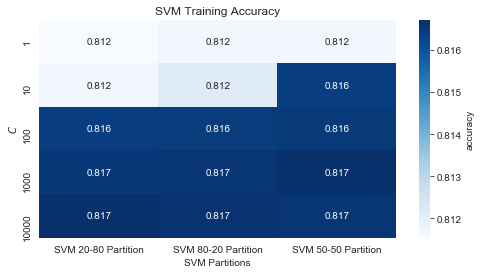

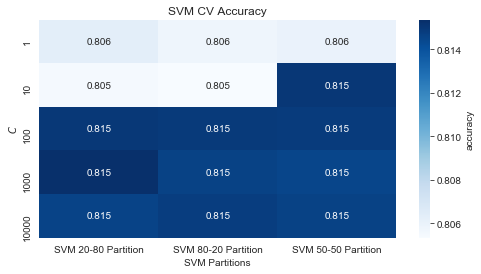

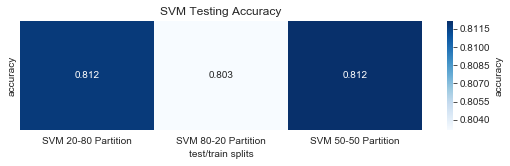

In [24]:
c_list = [1, 10, 100, 1000, 10000]
partition_names = ["SVM 20-80 Partition", "SVM 80-20 Partition", "SVM 50-50 Partition"]

svc_overall_train_acc = np.array([svc_avg_train_20_80, svc_avg_train_80_20, svc_avg_train_50_50])
svc_overall_train_acc = svc_overall_train_acc.reshape(5, 3)

svc_overall_cv_acc = np.array([svc_avg_cv_20_80, svc_avg_cv_80_20, svc_avg_cv_50_50])
svc_overall_cv_acc = svc_overall_cv_acc.reshape(5, 3)

svc_overall_test_acc = np.array([svc_avg_test_20_80, svc_avg_test_80_20, svc_avg_test_50_50]).reshape(1,3)

heatmap_SVM(svc_overall_train_acc, "SVM Training Accuracy", c_list, partition_names)
heatmap_SVM(svc_overall_cv_acc, "SVM CV Accuracy", c_list, partition_names)
heatmap_SVM(svc_overall_test_acc, "SVM Testing Accuracy", None, partition_names)

## KNN

In [17]:
# Training errors
knn_training_errors_20_80 = []
knn_training_errors_80_20 = []
knn_training_errors_50_50 = []

knn_cv_errors_20_80 = []
knn_cv_errors_80_20 = []
knn_cv_errors_50_50 = []

knn_testing_errors_20_80 = []
knn_testing_errors_80_20 = []
knn_testing_errors_50_50 = []

knn_train_partitions = [train_partition_20_80, train_partition_80_20, train_partition_50_50]
knn_test_partitions = [test_partition_20_80, test_partition_80_20, test_partition_50_50]

for val, partition in enumerate(knn_train_partitions):
    for ind in range(3):
        # KNN Model
        neighbors_estimator = neighbors.KNeighborsClassifier()

        k_list = [1, 2, 3, 4, 5]
        param_grid = {'n_neighbors': k_list}
        neighbors_grid_search = GridSearchCV(neighbors_estimator, param_grid, cv=5, return_train_score=True)

        # 3. Use the grid searcher to fit the training set.
        neighbors_grid_search.fit(partition[ind][0].tolist(), partition[ind][1].tolist())
        
        train_errors = neighbors_grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = neighbors_grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        test_errors = calc_acc(knn_test_partitions[val][ind][0].tolist(),
                               knn_test_partitions[val][ind][1].tolist(), neighbors_grid_search)
        if val == 0:
            knn_training_errors_20_80.append(train_errors)
            knn_cv_errors_20_80.append(cross_val_errors)
            knn_testing_errors_20_80.append(test_errors)
        elif val == 1:
            knn_training_errors_80_20.append(train_errors)
            knn_cv_errors_80_20.append(cross_val_errors)
            knn_testing_errors_80_20.append(test_errors)
        elif val == 2:
            knn_training_errors_50_50.append(train_errors)
            knn_cv_errors_50_50.append(cross_val_errors)
            knn_testing_errors_50_50.append(test_errors)

In [18]:
# Show the accuracy of the 20-80 partition
print(knn_training_errors_20_80[0])
print(knn_training_errors_20_80[1])
print(knn_training_errors_20_80[2])

knn_avg_train_20_80 = np.mean(knn_training_errors_20_80, axis=0)
knn_avg_train_80_20 = np.mean(knn_training_errors_80_20, axis=0)
knn_avg_train_50_50 = np.mean(knn_training_errors_50_50, axis=0)

knn_avg_cv_20_80 = np.mean(knn_cv_errors_20_80, axis=0)
knn_avg_cv_80_20 = np.mean(knn_cv_errors_80_20, axis=0)
knn_avg_cv_50_50 = np.mean(knn_cv_errors_50_50, axis=0)

knn_avg_test_20_80 = np.mean(knn_testing_errors_20_80, axis=0)
knn_avg_test_80_20 = np.mean(knn_testing_errors_80_20, axis=0)
knn_avg_test_50_50 = np.mean(knn_testing_errors_50_50, axis=0)

[[1.      ]
 [0.872375]
 [0.876625]
 [0.843625]
 [0.848625]]
[[1.      ]
 [0.879125]
 [0.880125]
 [0.84625 ]
 [0.857   ]]
[[1.      ]
 [0.869   ]
 [0.884875]
 [0.858875]
 [0.862625]]


In [19]:
def heatmap_KNN(acc_arr, title, k_list, split):
    if not k_list:
        plt.figure(figsize = (9,4))
        ax = sns.heatmap(acc_arr, annot=True, fmt='.3f', 
                         xticklabels=split, yticklabels='', cmap = "Blues")
        ax.collections[0].colorbar.set_label("accuracy")
        ax.set(xlabel = 'test/train splits', ylabel='accuracy')
        plt.title(title)
        sns.set_style("whitegrid", {'axes.grid' : False})
        plt.show()
        return
    plt.figure(figsize = (8,4))
    ax = sns.heatmap(acc_arr, annot=True, fmt='.3f', 
                     xticklabels=split, yticklabels=k_list, cmap = "Blues")
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = 'KNN Partitions', ylabel='$C$')
    plt.title(title)
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()

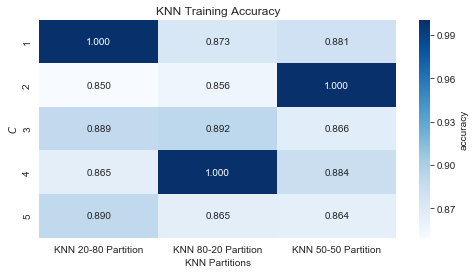

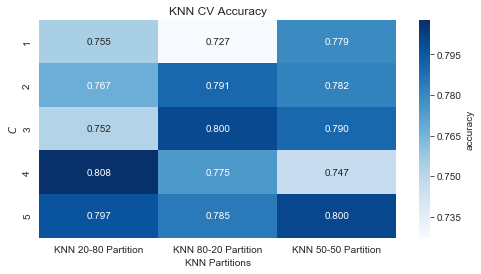

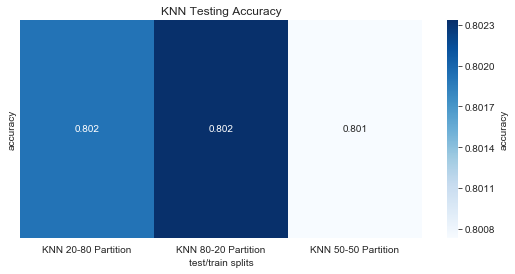

In [40]:
k_list = [1, 2, 3, 4, 5]
partition_names = ["KNN 20-80 Partition", "KNN 80-20 Partition", "KNN 50-50 Partition"]

knn_overall_train_acc = np.array([knn_avg_train_20_80, knn_avg_train_80_20, knn_avg_train_50_50])
knn_overall_train_acc = knn_overall_train_acc.reshape(5, 3)

knn_overall_cv_acc = np.array([knn_avg_cv_20_80, knn_avg_cv_80_20, knn_avg_cv_50_50])
knn_overall_cv_acc = knn_overall_cv_acc.reshape(5, 3)

knn_overall_test_acc = np.array([knn_avg_test_20_80,
                                 knn_avg_test_80_20, knn_avg_test_50_50]).reshape(1,3)

heatmap_KNN(knn_overall_train_acc, "KNN Training Accuracy", k_list, partition_names)
heatmap_KNN(knn_overall_cv_acc, "KNN CV Accuracy", k_list, partition_names)
heatmap_KNN(knn_overall_test_acc, "KNN Testing Accuracy", None, partition_names)

## Logistic Regression

In [25]:
# Training errors
lr_training_errors_20_80 = []
lr_training_errors_80_20 = []
lr_training_errors_50_50 = []

lr_cv_errors_20_80 = []
lr_cv_errors_80_20 = []
lr_cv_errors_50_50 = []

lr_testing_errors_20_80 = []
lr_testing_errors_80_20 = []
lr_testing_errors_50_50 = []

lr_train_partitions = [train_partition_20_80, train_partition_80_20, train_partition_50_50]
lr_test_partitions = [test_partition_20_80, test_partition_80_20, test_partition_50_50]

for val, partition in enumerate(lr_train_partitions):
    for ind in range(3):

        log_reg_estimator  = LogisticRegression(solver='liblinear', multi_class='ovr')
        c_list = [0.001, 0.01, 0.1, 1, 10]

        log_param_list = {'C': c_list}

        log_grid_search = GridSearchCV(log_reg_estimator, log_param_list, cv=5, return_train_score=True)
        log_grid_search.fit(partition[ind][0].tolist(), partition[ind][1].tolist())
        
        train_errors = log_grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = log_grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        test_errors = calc_acc(lr_test_partitions[val][ind][0].tolist(),
                               lr_test_partitions[val][ind][1].tolist(), log_grid_search)
        if val == 0:
            lr_training_errors_20_80.append(train_errors)
            lr_cv_errors_20_80.append(cross_val_errors)
            lr_testing_errors_20_80.append(test_errors)
        elif val == 1:
            lr_training_errors_80_20.append(train_errors)
            lr_cv_errors_80_20.append(cross_val_errors)
            lr_testing_errors_80_20.append(test_errors)
        elif val == 2:
            lr_training_errors_50_50.append(train_errors)
            lr_cv_errors_50_50.append(cross_val_errors)
            lr_testing_errors_50_50.append(test_errors)

In [26]:
# Show the accuracy of the 20-80 partition
print(lr_training_errors_20_80[0])
print(lr_training_errors_20_80[1])
print(lr_training_errors_20_80[2])

lr_avg_train_20_80 = np.mean(lr_training_errors_20_80, axis=0)
lr_avg_train_80_20 = np.mean(lr_training_errors_80_20, axis=0)
lr_avg_train_50_50 = np.mean(lr_training_errors_50_50, axis=0)

lr_avg_cv_20_80 = np.mean(lr_cv_errors_20_80, axis=0)
lr_avg_cv_80_20 = np.mean(lr_cv_errors_80_20, axis=0)
lr_avg_cv_50_50 = np.mean(lr_cv_errors_50_50, axis=0)

lr_avg_test_20_80 = np.mean(lr_testing_errors_20_80, axis=0)
lr_avg_test_80_20 = np.mean(lr_testing_errors_80_20, axis=0)
lr_avg_test_50_50 = np.mean(lr_testing_errors_50_50, axis=0)

[[0.793625]
 [0.803875]
 [0.804625]
 [0.804375]
 [0.804375]]
[[0.814875]
 [0.815875]
 [0.81675 ]
 [0.815875]
 [0.815625]]
[[0.80875 ]
 [0.809375]
 [0.80875 ]
 [0.807875]
 [0.807875]]


In [27]:
def heatmap_Log(acc_arr, title, c_list, split):
    if not c_list:
        plt.figure(figsize = (9,2))
        ax = sns.heatmap(acc_arr, annot=True, fmt='.3f', 
                         xticklabels=split, yticklabels='', cmap = "Blues")
        ax.collections[0].colorbar.set_label("accuracy")
        ax.set(xlabel = 'test/train splits', ylabel='accuracy')
        plt.title(title)
        sns.set_style("whitegrid", {'axes.grid' : False})
        plt.show()
        return
    plt.figure(figsize = (8,4))
    ax = sns.heatmap(acc_arr, annot=True, fmt='.3f', 
                     xticklabels=split, yticklabels=c_list, cmap = "Blues")
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = 'Log Reg. Partitions', ylabel='$C$')
    plt.title(title)
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()

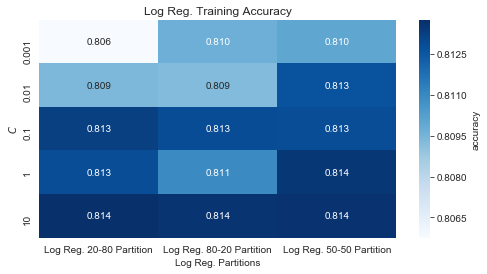

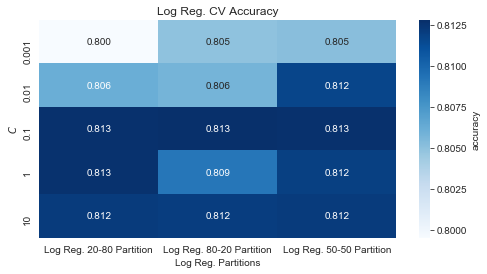

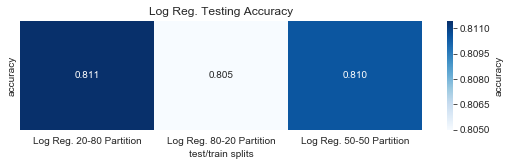

In [28]:
c_list = [0.001, 0.01, 0.1, 1, 10]
partition_names = ["Log Reg. 20-80 Partition", "Log Reg. 80-20 Partition", "Log Reg. 50-50 Partition"]

lr_overall_train_acc = np.array([lr_avg_train_20_80, lr_avg_train_80_20, lr_avg_train_50_50])
lr_overall_train_acc = lr_overall_train_acc.reshape(5, 3)

lr_overall_cv_acc = np.array([lr_avg_cv_20_80, lr_avg_cv_80_20, lr_avg_cv_50_50])
lr_overall_cv_acc = lr_overall_cv_acc.reshape(5, 3)

lr_overall_test_acc = np.array([lr_avg_test_20_80, lr_avg_test_80_20, lr_avg_test_50_50]).reshape(1,3)

heatmap_Log(lr_overall_train_acc, "Log Reg. Training Accuracy", c_list, partition_names)
heatmap_Log(lr_overall_cv_acc, "Log Reg. CV Accuracy", c_list, partition_names)
heatmap_Log(lr_overall_test_acc, "Log Reg. Testing Accuracy", None, partition_names)

## Decision Tree

In [29]:
# Training errors
dt_training_errors_20_80 = []
dt_training_errors_80_20 = []
dt_training_errors_50_50 = []

dt_cv_errors_20_80 = []
dt_cv_errors_80_20 = []
dt_cv_errors_50_50 = []

dt_testing_errors_20_80 = []
dt_testing_errors_80_20 = []
dt_testing_errors_50_50 = []

dt_train_partitions = [train_partition_20_80, train_partition_80_20, train_partition_50_50]
dt_test_partitions = [test_partition_20_80, test_partition_80_20, test_partition_50_50]

for val, partition in enumerate(dt_train_partitions):
    for ind in range(3):
        
        dt_estimator = DecisionTreeClassifier(criterion = 'entropy')
        D_list = [1, 2, 3, 4, 5]

        dt_param_list = {'max_depth': D_list}
        tree_grid_search = GridSearchCV(dt_estimator, dt_param_list, cv = 5, return_train_score=True)
        tree_grid_search.fit(partition[ind][0].tolist(), partition[ind][1].tolist())
        
        train_errors = tree_grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = tree_grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        test_errors = calc_acc(dt_test_partitions[val][ind][0].tolist(),
                               dt_test_partitions[val][ind][1].tolist(), tree_grid_search)
        if val == 0:
            dt_training_errors_20_80.append(train_errors)
            dt_cv_errors_20_80.append(cross_val_errors)
            dt_testing_errors_20_80.append(test_errors)
        elif val == 1:
            dt_training_errors_80_20.append(train_errors)
            dt_cv_errors_80_20.append(cross_val_errors)
            dt_testing_errors_80_20.append(test_errors)
        elif val == 2:
            dt_training_errors_50_50.append(train_errors)
            dt_cv_errors_50_50.append(cross_val_errors)
            dt_testing_errors_50_50.append(test_errors)

In [30]:
# Show the accuracy of the 20-80 partition
print(dt_training_errors_20_80[0])
print(dt_training_errors_20_80[1])
print(dt_training_errors_20_80[2])

dt_avg_train_20_80 = np.mean(dt_training_errors_20_80, axis=0)
dt_avg_train_80_20 = np.mean(dt_training_errors_80_20, axis=0)
dt_avg_train_50_50 = np.mean(dt_training_errors_50_50, axis=0)

dt_avg_cv_20_80 = np.mean(dt_cv_errors_20_80, axis=0)
dt_avg_cv_80_20 = np.mean(dt_cv_errors_80_20, axis=0)
dt_avg_cv_50_50 = np.mean(dt_cv_errors_50_50, axis=0)

dt_avg_test_20_80 = np.mean(dt_testing_errors_20_80, axis=0)
dt_avg_test_80_20 = np.mean(dt_testing_errors_80_20, axis=0)
dt_avg_test_50_50 = np.mean(dt_testing_errors_50_50, axis=0)

[[0.7445  ]
 [0.792875]
 [0.795875]
 [0.810125]
 [0.8245  ]]
[[0.763   ]
 [0.809   ]
 [0.817   ]
 [0.829875]
 [0.8465  ]]
[[0.7635  ]
 [0.8015  ]
 [0.8085  ]
 [0.818125]
 [0.836625]]


In [31]:
def heatmap_DT(acc_arr, title, d_list, split):
    if not d_list:
        plt.figure(figsize = (9,2))
        ax = sns.heatmap(acc_arr, annot=True, fmt='.3f', 
                         xticklabels=split, yticklabels='', cmap = "Blues")
        ax.collections[0].colorbar.set_label("accuracy")
        ax.set(xlabel = 'test/train splits', ylabel='accuracy')
        plt.title(title)
        sns.set_style("whitegrid", {'axes.grid' : False})
        plt.show()
        return
    plt.figure(figsize = (8,4))
    ax = sns.heatmap(acc_arr, annot=True, fmt='.3f', 
                     xticklabels=split, yticklabels=d_list, cmap = "Blues")
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = 'DT Partitions', ylabel='$C$')
    plt.title(title)
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()

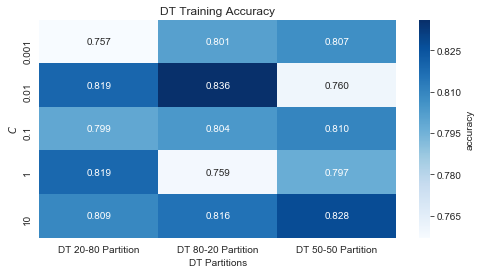

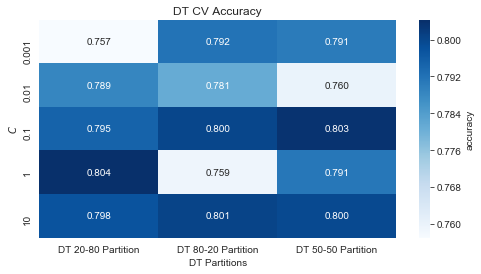

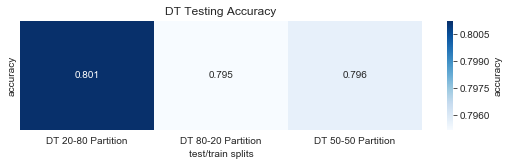

In [32]:
D_list = [1, 2, 3, 4, 5]
partition_names = ["DT 20-80 Partition", "DT 80-20 Partition", "DT 50-50 Partition"]

dt_overall_train_acc = np.array([dt_avg_train_20_80, dt_avg_train_80_20, dt_avg_train_50_50])
dt_overall_train_acc = dt_overall_train_acc.reshape(5, 3)

dt_overall_cv_acc = np.array([dt_avg_cv_20_80, dt_avg_cv_80_20, dt_avg_cv_50_50])
dt_overall_cv_acc = dt_overall_cv_acc.reshape(5, 3)

dt_overall_test_acc = np.array([dt_avg_test_20_80, dt_avg_test_80_20, dt_avg_test_50_50]).reshape(1,3)

heatmap_DT(dt_overall_train_acc, "DT Training Accuracy", c_list, partition_names)
heatmap_DT(dt_overall_cv_acc, "DT CV Accuracy", c_list, partition_names)
heatmap_DT(dt_overall_test_acc, "DT Testing Accuracy", None, partition_names)

## Random Forest

In [33]:
# Training errors
rf_training_errors_20_80 = []
rf_training_errors_80_20 = []
rf_training_errors_50_50 = []

rf_cv_errors_20_80 = []
rf_cv_errors_80_20 = []
rf_cv_errors_50_50 = []

rf_testing_errors_20_80 = []
rf_testing_errors_80_20 = []
rf_testing_errors_50_50 = []

rf_train_partitions = [train_partition_20_80, train_partition_80_20, train_partition_50_50]
rf_test_partitions = [test_partition_20_80, test_partition_80_20, test_partition_50_50]

for val, partition in enumerate(rf_train_partitions):
    for ind in range(3):
        
        rf_estimator = RandomForestClassifier(n_estimators = 300, criterion = 'entropy')
        D_list = [1, 2, 3, 4, 5]

        rf_param_list = {'max_depth': D_list}
        rf_grid_search = GridSearchCV(rf_estimator, rf_param_list, cv = 5, return_train_score=True)
        rf_grid_search.fit(partition[ind][0].tolist(), partition[ind][1].tolist())
        
        train_errors = rf_grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = rf_grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        test_errors = calc_acc(rf_test_partitions[val][ind][0].tolist(),
                               rf_test_partitions[val][ind][1].tolist(), rf_grid_search)
        if val == 0:
            rf_training_errors_20_80.append(train_errors)
            rf_cv_errors_20_80.append(cross_val_errors)
            rf_testing_errors_20_80.append(test_errors)
        elif val == 1:
            rf_training_errors_80_20.append(train_errors)
            rf_cv_errors_80_20.append(cross_val_errors)
            rf_testing_errors_80_20.append(test_errors)
        elif val == 2:
            rf_training_errors_50_50.append(train_errors)
            rf_cv_errors_50_50.append(cross_val_errors)
            rf_testing_errors_50_50.append(test_errors)

In [34]:
# Show the accuracy of the 20-80 partition
print(rf_training_errors_20_80[0])
print(rf_training_errors_20_80[1])
print(rf_training_errors_20_80[2])

rf_avg_train_20_80 = np.mean(rf_training_errors_20_80, axis=0)
rf_avg_train_80_20 = np.mean(rf_training_errors_80_20, axis=0)
rf_avg_train_50_50 = np.mean(rf_training_errors_50_50, axis=0)

rf_avg_cv_20_80 = np.mean(rf_cv_errors_20_80, axis=0)
rf_avg_cv_80_20 = np.mean(rf_cv_errors_80_20, axis=0)
rf_avg_cv_50_50 = np.mean(rf_cv_errors_50_50, axis=0)

rf_avg_test_20_80 = np.mean(rf_testing_errors_20_80, axis=0)
rf_avg_test_80_20 = np.mean(rf_testing_errors_80_20, axis=0)
rf_avg_test_50_50 = np.mean(rf_testing_errors_50_50, axis=0)

[[0.7445  ]
 [0.7445  ]
 [0.799875]
 [0.81775 ]
 [0.832375]]
[[0.763   ]
 [0.763   ]
 [0.809625]
 [0.831125]
 [0.84575 ]]
[[0.7635  ]
 [0.7635  ]
 [0.800625]
 [0.817625]
 [0.83725 ]]


In [35]:
def heatmap_RF(acc_arr, title, rf_list, split):
    if not rf_list:
        plt.figure(figsize = (9,2))
        ax = sns.heatmap(acc_arr, annot=True, fmt='.3f', 
                         xticklabels=split, yticklabels='', cmap = "Blues")
        ax.collections[0].colorbar.set_label("accuracy")
        ax.set(xlabel = 'test/train splits', ylabel='accuracy')
        plt.title(title)
        sns.set_style("whitegrid", {'axes.grid' : False})
        plt.show()
        return
    plt.figure(figsize = (8,4))
    ax = sns.heatmap(acc_arr, annot=True, fmt='.3f', 
                     xticklabels=split, yticklabels=rf_list, cmap = "Blues")
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = 'RF Partitions', ylabel='$C$')
    plt.title(title)
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()


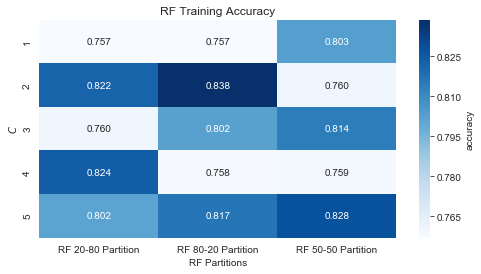

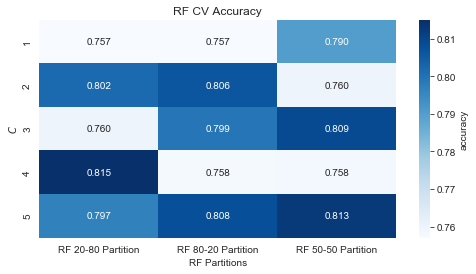

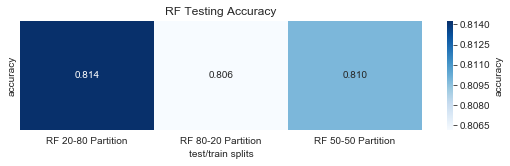

In [36]:
D_list = [1, 2, 3, 4, 5]
partition_names = ["RF 20-80 Partition", "RF 80-20 Partition", "RF 50-50 Partition"]

rf_overall_train_acc = np.array([rf_avg_train_20_80, rf_avg_train_80_20, rf_avg_train_50_50])
rf_overall_train_acc = rf_overall_train_acc.reshape(5, 3)

rf_overall_cv_acc = np.array([rf_avg_cv_20_80, rf_avg_cv_80_20, rf_avg_cv_50_50])
rf_overall_cv_acc = rf_overall_cv_acc.reshape(5, 3)

rf_overall_test_acc = np.array([rf_avg_test_20_80, rf_avg_test_80_20, rf_avg_test_50_50]).reshape(1,3)

heatmap_RF(rf_overall_train_acc, "RF Training Accuracy", D_list, partition_names)
heatmap_RF(rf_overall_cv_acc, "RF CV Accuracy", D_list, partition_names)
heatmap_RF(rf_overall_test_acc, "RF Testing Accuracy", None, partition_names)

# Look at the test results for all 5 Classifiers

In [37]:
print("Support Vector Machine Test Accuracy: ", svc_overall_test_acc)
print("K-Nearest Neighbors Test Accuracy: ", knn_overall_test_acc)
print("Logistic Regression Test Accuracy: ", lr_overall_test_acc)
print("Decision Tree Test Accuracy: ", dt_overall_test_acc)
print("Random forest Test Accuracy: ", rf_overall_test_acc)

Support Vector Machine Test Accuracy:  [[0.81175    0.80316667 0.81213333]]
K-Nearest Neighbors Test Accuracy:  [[0.80191667 0.80233333 0.80073333]]
Logistic Regression Test Accuracy:  [[0.81141667 0.805      0.81046667]]
Decision Tree Test Accuracy:  [[0.80125    0.79516667 0.79566667]]
Random forest Test Accuracy:  [[0.81425    0.80616667 0.80986667]]


In [38]:
def heatmap_overall(acc_arr, title, rf_list, split):

    plt.figure(figsize = (16,8))
    ax = sns.heatmap(acc_arr, annot=True, fmt='.3f', 
                     xticklabels=split, yticklabels=rf_list, cmap = "Blues")
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = 'Overall Partitions', ylabel='$C$')
    plt.title(title)
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()

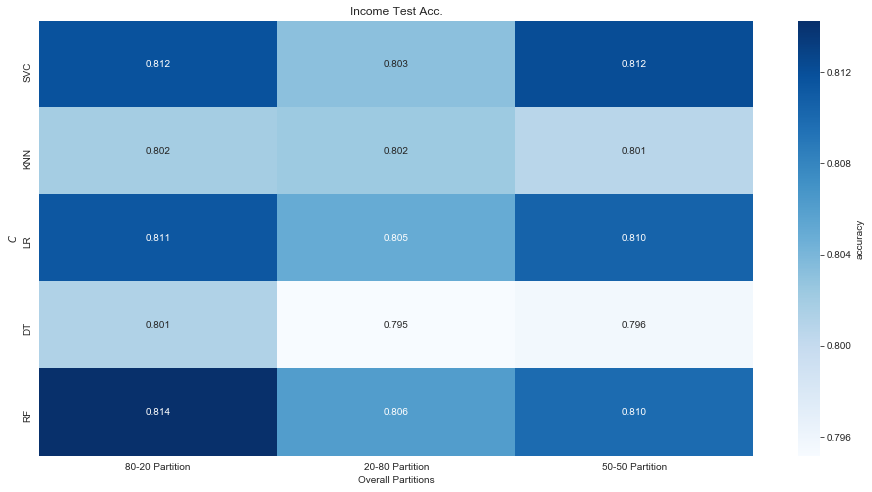

In [41]:
income_results = np.array([svc_overall_test_acc, knn_overall_test_acc, 
                                lr_overall_test_acc, dt_overall_test_acc,
                                rf_overall_test_acc])
income_results = income_results.reshape(5, 3)
partition_names = ["80-20 Partition", "20-80 Partition", "50-50 Partition"]
y_axis_labels = ['SVC', 'KNN', 'LR', 'DT', 'RF']

heatmap_overall(income_results, "Income Test Acc.", y_axis_labels, partition_names)